In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd
from matplotlib.lines import Line2D
pd.set_option('mode.chained_assignment', None)

ModuleNotFoundError: No module named 'contextily'

## Read GPS trace data

In [2]:
data = pd.read_csv('demo.csv')

## Read highway data

In [3]:
hwy = gpd.read_file('zip://Highways.zip')

## Add buffer to highway

In [4]:
buffer=hwy.to_crs(epsg=3857).buffer(50)
buffer.index=hwy['Name']

## Spatial Join

In [5]:
data.sort_values(by='TIMESTAMP_EPOCH_MILLISECOND',inplace=True)
geo_data = gpd.GeoDataFrame(data.copy(), geometry=gpd.points_from_xy(data.GEOHASHLONGITUDE, data.GEOHASHLATITUDE),
                                   crs={'init': 'epsg:4326','no_defs': True})

In [6]:
area = buffer.to_crs(epsg=4326)
area = gpd.GeoDataFrame(geometry=area)
joint = gpd.sjoin(left_df=geo_data, right_df=area,how="inner", op='within')
joint.drop_duplicates(subset=['GRAVYREGISTRATIONID', 'TIMESTAMP_EPOCH_MILLISECOND'], keep='first',inplace=True)

## Extract proxy entrance and exit

In [7]:
entrance = joint.iloc[0,:]
exit = joint.iloc[-1,:]
entrance_index = joint.index[0]
exit_index = joint.index[-1]

## Visualization

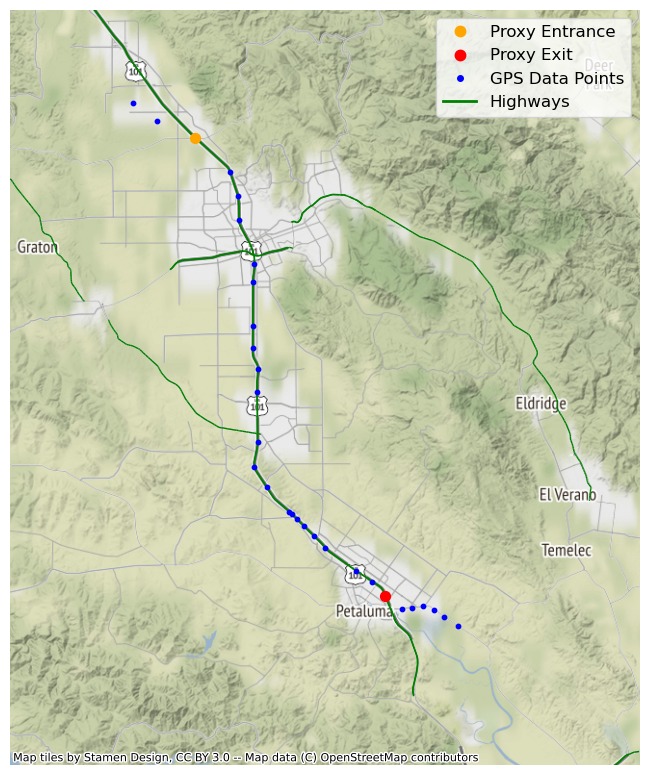

In [8]:
fig, ax = plt.subplots(1, 1,figsize=(10, 10),dpi=100)
hwy.to_crs(epsg=3857).plot(ax=ax,facecolor='none',edgecolor='g', linewidth = 1, zorder=1, alpha=1)
geo_data.to_crs(epsg=3857).plot(ax=ax,color='b',markersize=10, zorder=2)
geo_data.to_crs(epsg=3857).loc[[entrance_index]].plot(ax=ax,color='orange',markersize=50, zorder=3)
geo_data.to_crs(epsg=3857).loc[[exit_index]].plot(ax=ax,color='r',markersize=50, zorder=3)


legend_elements = [Line2D([0], [0], marker='.', color='orange', lw=0, markersize=15, label='Proxy Entrance'),
                   Line2D([0], [0], marker='.', color='r', lw=0, markersize=15, label='Proxy Exit'),
                   Line2D([0], [0], marker='.', color='b', lw=0, markersize=8, label='GPS Data Points'),
                   Line2D([0], [0], marker='.', color='g', lw=2, markersize=0, markerfacecolor='k', label='Highways'),
                  ]
ax.legend(handles=legend_elements,fontsize=12)

ax.set_ylim(4600000, 4660000)
ax.set_xlim(-13680000, -13630000)
ax.axis('off')

cx.add_basemap(ax)